In [1]:
# ================================
# Fire-spotter (PU): positives = detections, negatives = sampled background
# ================================
# Outputs:
#   - fire_prob.tif  (float32, 0..1)
#   - fire_mask.tif  (uint8, {0,1}) at selected threshold
#
# Notes:
# - Works with your single-band EPSG:3857 raster (nodata=65555.0).
# - Detections are treated as positive labels; negatives are sampled away from them.
# - Features: z-scored value, local mean/std (3x3, 5x5), edges (Sobel), LoG.
# - Tweak NEG_POS_RATIO, BUFFER_PX, and THRESHOLD to your liking.

# ---------- USER SETTINGS ----------
RASTER_PATH   = "Dataset_2/F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_MWIR.tif"   # your GeoTIFF path
DETECT_PATH   = "Dataset_2/F002_L1__IR__L2L1M0__2025-08-12T212259.010953Z_2025-08-13T111644.731945Z_e81989f5_model_detections.geojson"
OUT_PROB_TIF  = "fire_prob.tif"
OUT_MASK_TIF  = "fire_mask.tif"
THRESHOLD     = 0.5          # probability cutoff for binary mask
NEG_POS_RATIO = 3            # sample this many negatives per positive
BUFFER_PX     = 5            # exclude negatives within this many pixels of any positive
RANDOM_STATE  = 42
# -----------------------------------

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import rasterize
from rasterio.transform import Affine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from scipy.ndimage import uniform_filter, gaussian_laplace, sobel, distance_transform_edt

# -----------------------
# 1) LOAD RASTER & CLEAN
# -----------------------
with rasterio.open(RASTER_PATH) as src:
    prof = src.profile.copy()
    band = src.read(1).astype(np.float32)
    transform = src.transform
    crs = src.crs
    nodata = prof.get("nodata", 65555.0)

valid = np.isfinite(band) & (band != nodata)
band = np.where(valid, band, np.nan)

# Z-score over valid pixels (robust enough here)
mu = np.nanmean(band)
sd = np.nanstd(band) + 1e-6
z = (band - mu) / sd

# ------------------------------------------------
# 2) READ DETECTIONS → POSITIVE PIXELS (row, col)
# ------------------------------------------------
# The file may already be lon/lat columns or point geometries.
# We'll try to read as GeoDataFrame; if CRS missing, assume WGS84 (EPSG:4326) and project.
gdf = gpd.read_file(DETECT_PATH)

# If no geometry, build it from lon/lat columns
if gdf.geometry.isna().all():
    if not {"lon", "lat"}.issubset(gdf.columns):
        raise ValueError("Detections file must have geometry or 'lon'/'lat' columns.")
    gdf = gpd.GeoDataFrame(
        gdf,
        geometry=gpd.points_from_xy(gdf["lon"], gdf["lat"]),
        crs="EPSG:4326"
    )

# Ensure detections are in raster CRS
if gdf.crs is None:
    # If still none, assume WGS84 then reproject
    gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(crs)

# Map points → (row, col)
def world_to_rc(x, y, affine: Affine):
    col, row = ~affine * (x, y)
    return int(np.floor(row)), int(np.floor(col))

pos_rc = []
for pt in gdf.geometry:
    r, c = world_to_rc(pt.x, pt.y, transform)
    if 0 <= r < band.shape[0] and 0 <= c < band.shape[1] and np.isfinite(band[r, c]):
        pos_rc.append((r, c))
pos_rc = np.array(pos_rc, dtype=int)

if len(pos_rc) == 0:
    raise ValueError("No valid positive pixels found inside the raster bounds.")

# ------------------------------------------------
# 3) FEATURE ENGINEERING (LOCAL CONTEXT)
# ------------------------------------------------
def nanmean_filter(x, size):
    v = np.isfinite(x).astype(np.float32)
    s = uniform_filter(np.nan_to_num(x, nan=0.0), size=size, mode="nearest")
    c = uniform_filter(v, size=size, mode="nearest")
    out = np.where(c > 0, s / np.maximum(c, 1e-6), np.nan)
    return out

mean3 = nanmean_filter(z, 3)
mean5 = nanmean_filter(z, 5)
# local std (3x3) via E[X^2] - (E[X])^2
sq = z**2
mean3_sq = nanmean_filter(sq, 3)
std3 = np.sqrt(np.clip(mean3_sq - mean3**2, 0, None))

# edges / blobs
sx = sobel(z, axis=1, mode="nearest")
sy = sobel(z, axis=0, mode="nearest")
grad_mag = np.hypot(sx, sy)
log_resp = -gaussian_laplace(z, sigma=1)

# Stack features (H, W, F)
feat = np.stack([z, mean3, std3, mean5, grad_mag, log_resp], axis=-1)

# Replace remaining NaNs in features with 0 (neutral)
feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)

# --------------------------------------------
# 4) BUILD TRAIN SET: POSITIVES & BACKGROUND
# --------------------------------------------
H, W, F = feat.shape
pos_idx = pos_rc[:, 0] * W + pos_rc[:, 1]

# Build a positive mask raster to exclude nearby negatives
pos_mask = np.zeros((H, W), dtype=bool)
pos_mask.flat[pos_idx] = True

# Distance (in pixels) to nearest positive; exclude within BUFFER_PX
# (distance_transform_edt operates on False=background, True=objects; invert)
dist = distance_transform_edt(~pos_mask)
far_enough = dist > BUFFER_PX

# Valid candidates for negatives: valid pixels, far from positives, not NaN
neg_candidates = valid & far_enough & (~pos_mask)

n_pos = len(pos_idx)
n_neg = min(int(NEG_POS_RATIO * n_pos), int(neg_candidates.sum()))
if n_neg <= 0:
    raise ValueError("No valid background pixels available for negatives. Try reducing BUFFER_PX.")

neg_lin = np.flatnonzero(neg_candidates)
rng = np.random.default_rng(RANDOM_STATE)
neg_sample = rng.choice(neg_lin, size=n_neg, replace=False)

# Compose training arrays
X_pos = feat.reshape(-1, F)[pos_idx]
X_neg = feat.reshape(-1, F)[neg_sample]
y_pos = np.ones(len(X_pos), dtype=np.uint8)
y_neg = np.zeros(len(X_neg), dtype=np.uint8)

X = np.vstack([X_pos, X_neg])
y = np.concatenate([y_pos, y_neg])

# Optional quick train/val split to sanity-check
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# -----------------------------
# 5) TRAIN A RANDOM FOREST
# -----------------------------
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
clf.fit(Xtr, ytr)

# Quick validation metrics
proba_te = clf.predict_proba(Xte)[:, 1]
# print("Validation AUC:", roc_auc_score(yte, proba_te).round(3))
print(classification_report(yte, (proba_te >= THRESHOLD).astype(int), digits=3))

# ---------------------------------------
# 6) FULL-IMAGE PREDICTION + SAVE GEOTIFF
# ---------------------------------------
flat_feat = feat.reshape(-1, F)
flat_prob = np.zeros(flat_feat.shape[0], dtype=np.float32)
flat_prob[:] = np.nan

# Only predict where valid
valid_lin = np.flatnonzero(valid.reshape(-1))
flat_prob[valid_lin] = clf.predict_proba(flat_feat[valid_lin])[:, 1].astype(np.float32)

prob = flat_prob.reshape(H, W)
mask = (prob >= THRESHOLD).astype(np.uint8)
mask[~valid] = 0  # enforce 0 over nodata

# Save probability
prob_prof = prof.copy()
prob_prof.update(dtype="float32", count=1, nodata=None, compress="deflate", predictor=2)
with rasterio.open(OUT_PROB_TIF, "w", **prob_prof) as dst:
    dst.write(prob, 1)

# Save binary mask
mask_prof = prof.copy()
mask_prof.update(dtype="uint8", count=1, nodata=0, compress="deflate")
with rasterio.open(OUT_MASK_TIF, "w", **mask_prof) as dst:
    dst.write(mask, 1)

print(f"Wrote {OUT_PROB_TIF} and {OUT_MASK_TIF}")


              precision    recall  f1-score   support

           0      1.000     1.000     1.000        16
           1      1.000     1.000     1.000         5

    accuracy                          1.000        21
   macro avg      1.000     1.000     1.000        21
weighted avg      1.000     1.000     1.000        21

Wrote fire_prob.tif and fire_mask.tif


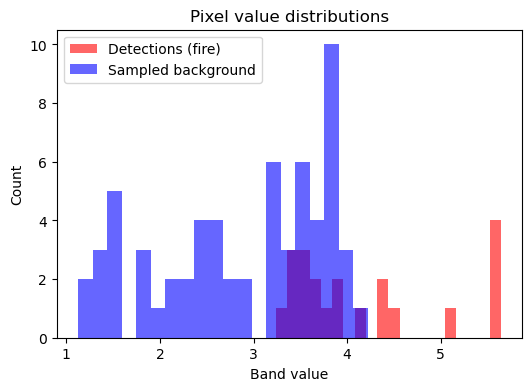

In [ ]:
import matplotlib.pyplot as plt

# Compare the raw band values at positives vs. negatives
vals_pos = band[pos_rc[:,0], pos_rc[:,1]]
vals_neg = band.reshape(-1)[neg_sample]

plt.figure(figsize=(6,4))
plt.hist(vals_pos, bins=20, alpha=0.6, label="Detections (fire)", color="red")
plt.hist(vals_neg, bins=20, alpha=0.6, label="Sampled background", color="blue")
plt.xlabel("Band value")
plt.ylabel("Count")
plt.legend()
plt.title("Pixel value distributions")
plt.show()


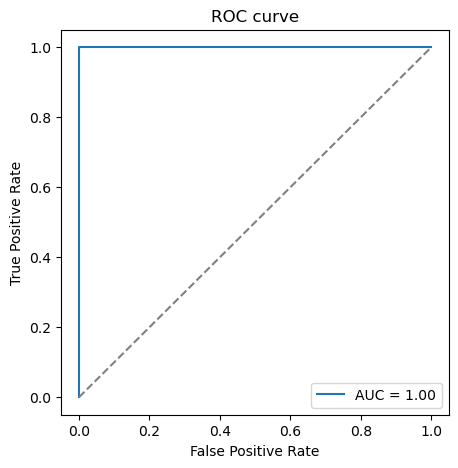

In [ ]:
# from sklearn.metrics import roc_curve, auc

# fpr, tpr, _ = roc_curve(yte, proba_te)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(5,5))
# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
# plt.plot([0,1],[0,1],'--',color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC curve")
# plt.legend()
# plt.show()


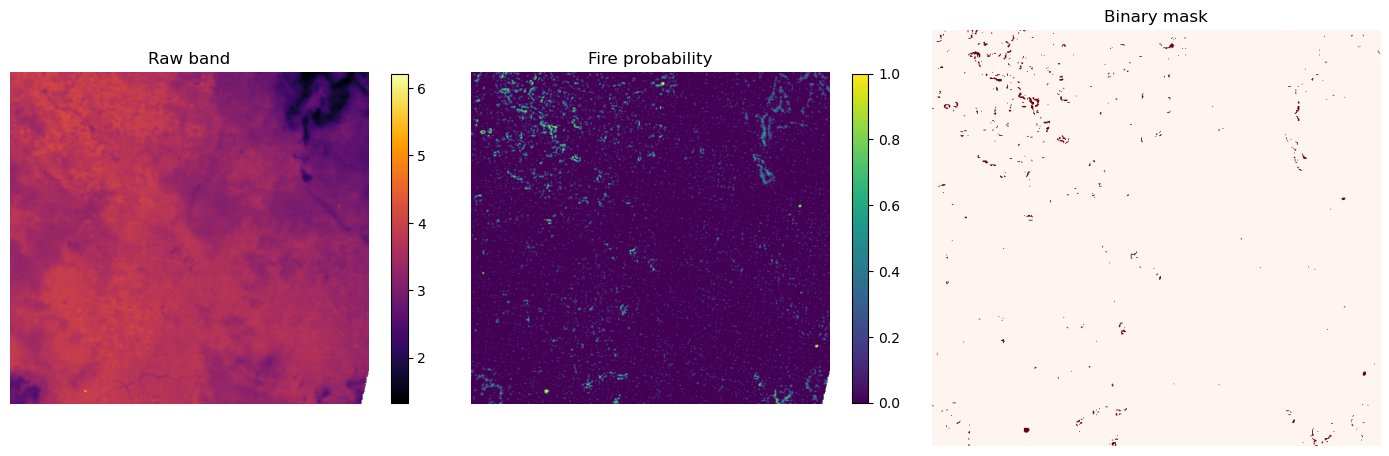

In [ ]:
# Pick a bounding box around detections for zoom-in
rmin, rmax = pos_rc[:,0].min()-20, pos_rc[:,0].max()+20
cmin, cmax = pos_rc[:,1].min()-20, pos_rc[:,1].max()+20

fig, axs = plt.subplots(1,3,figsize=(14,5))

# Raw band
im0 = axs[0].imshow(band[rmin:rmax, cmin:cmax], cmap="inferno")
axs[0].set_title("Raw band")
plt.colorbar(im0, ax=axs[0], shrink=0.7)

# Probability
im1 = axs[1].imshow(prob[rmin:rmax, cmin:cmax], cmap="viridis", vmin=0, vmax=1)
axs[1].set_title("Fire probability")
plt.colorbar(im1, ax=axs[1], shrink=0.7)

# Mask
axs[2].imshow(mask[rmin:rmax, cmin:cmax], cmap="Reds")
axs[2].set_title("Binary mask")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


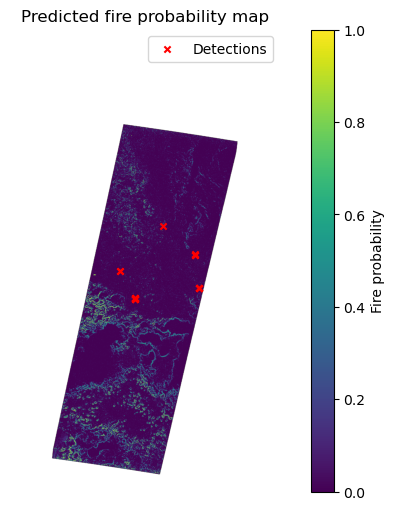

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(prob, cmap="viridis", vmin=0, vmax=1)
plt.colorbar(label="Fire probability")
plt.scatter(pos_rc[:,1], pos_rc[:,0], c="red", s=20, marker="x", label="Detections")
plt.title("Predicted fire probability map")
plt.legend()
plt.axis("off")
plt.show()


In [1]:
# ================================
# Fire-spotter (PU): positives = detections, negatives = sampled background
# ================================
# Outputs:
#   - fire_prob.tif  (float32, 0..1)
#   - fire_mask.tif  (uint8, {0,1}) at selected threshold
#
# Notes:
# - Works with your single-band EPSG:3857 raster (nodata=65555.0).
# - Detections are treated as positive labels; negatives are sampled away from them.
# - Features: z-scored value, local mean/std (3x3, 5x5), edges (Sobel), LoG.
# - Tweak NEG_POS_RATIO, BUFFER_PX, and THRESHOLD to your liking.

# ---------- USER SETTINGS ----------
RASTER_PATH   = "Dataset_1/F002_L1__IR__L2L1M0__2025-01-10T215412.018348Z_2025-04-10T154832.806087Z_97706189_MWIR.tif"   # your GeoTIFF path
DETECT_PATH   = "Dataset_1/F002_L1__IR__L2L1M0__2025-01-10T215412.018348Z_2025-04-10T154832.806087Z_97706189_model_detections.geojson"
OUT_PROB_TIF  = "fire_prob.tif"
OUT_MASK_TIF  = "fire_mask.tif"
THRESHOLD     = 0.5          # probability cutoff for binary mask
NEG_POS_RATIO = 3            # sample this many negatives per positive
BUFFER_PX     = 5            # exclude negatives within this many pixels of any positive
RANDOM_STATE  = 42
# -----------------------------------

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.features import rasterize
from rasterio.transform import Affine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from scipy.ndimage import uniform_filter, gaussian_laplace, sobel, distance_transform_edt

# -----------------------
# 1) LOAD RASTER & CLEAN
# -----------------------
with rasterio.open(RASTER_PATH) as src:
    prof = src.profile.copy()
    band = src.read(1).astype(np.float32)
    transform = src.transform
    crs = src.crs
    nodata = prof.get("nodata", 65555.0)

valid = np.isfinite(band) & (band != nodata)
band = np.where(valid, band, np.nan)

# Z-score over valid pixels (robust enough here)
mu = np.nanmean(band)
sd = np.nanstd(band) + 1e-6
z = (band - mu) / sd

# ------------------------------------------------
# 2) READ DETECTIONS → POSITIVE PIXELS (row, col)
# ------------------------------------------------
# The file may already be lon/lat columns or point geometries.
# We'll try to read as GeoDataFrame; if CRS missing, assume WGS84 (EPSG:4326) and project.
gdf = gpd.read_file(DETECT_PATH)

# If no geometry, build it from lon/lat columns
if gdf.geometry.isna().all():
    if not {"lon", "lat"}.issubset(gdf.columns):
        raise ValueError("Detections file must have geometry or 'lon'/'lat' columns.")
    gdf = gpd.GeoDataFrame(
        gdf,
        geometry=gpd.points_from_xy(gdf["lon"], gdf["lat"]),
        crs="EPSG:4326"
    )

# Ensure detections are in raster CRS
if gdf.crs is None:
    # If still none, assume WGS84 then reproject
    gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(crs)

# Map points → (row, col)
def world_to_rc(x, y, affine: Affine):
    col, row = ~affine * (x, y)
    return int(np.floor(row)), int(np.floor(col))

pos_rc = []
for pt in gdf.geometry:
    r, c = world_to_rc(pt.x, pt.y, transform)
    if 0 <= r < band.shape[0] and 0 <= c < band.shape[1] and np.isfinite(band[r, c]):
        pos_rc.append((r, c))
pos_rc = np.array(pos_rc, dtype=int)

if len(pos_rc) == 0:
    raise ValueError("No valid positive pixels found inside the raster bounds.")

# ------------------------------------------------
# 3) FEATURE ENGINEERING (LOCAL CONTEXT)
# ------------------------------------------------
def nanmean_filter(x, size):
    v = np.isfinite(x).astype(np.float32)
    s = uniform_filter(np.nan_to_num(x, nan=0.0), size=size, mode="nearest")
    c = uniform_filter(v, size=size, mode="nearest")
    out = np.where(c > 0, s / np.maximum(c, 1e-6), np.nan)
    return out

mean3 = nanmean_filter(z, 3)
mean5 = nanmean_filter(z, 5)
# local std (3x3) via E[X^2] - (E[X])^2
sq = z**2
mean3_sq = nanmean_filter(sq, 3)
std3 = np.sqrt(np.clip(mean3_sq - mean3**2, 0, None))

# edges / blobs
sx = sobel(z, axis=1, mode="nearest")
sy = sobel(z, axis=0, mode="nearest")
grad_mag = np.hypot(sx, sy)
log_resp = -gaussian_laplace(z, sigma=1)

# Stack features (H, W, F)
feat = np.stack([z, mean3, std3, mean5, grad_mag, log_resp], axis=-1)

# Replace remaining NaNs in features with 0 (neutral)
feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)

# --------------------------------------------
# 4) BUILD TRAIN SET: POSITIVES & BACKGROUND
# --------------------------------------------
H, W, F = feat.shape
pos_idx = pos_rc[:, 0] * W + pos_rc[:, 1]

# Build a positive mask raster to exclude nearby negatives
pos_mask = np.zeros((H, W), dtype=bool)
pos_mask.flat[pos_idx] = True

# Distance (in pixels) to nearest positive; exclude within BUFFER_PX
# (distance_transform_edt operates on False=background, True=objects; invert)
dist = distance_transform_edt(~pos_mask)
far_enough = dist > BUFFER_PX

# Valid candidates for negatives: valid pixels, far from positives, not NaN
neg_candidates = valid & far_enough & (~pos_mask)

n_pos = len(pos_idx)
n_neg = min(int(NEG_POS_RATIO * n_pos), int(neg_candidates.sum()))
if n_neg <= 0:
    raise ValueError("No valid background pixels available for negatives. Try reducing BUFFER_PX.")

neg_lin = np.flatnonzero(neg_candidates)
rng = np.random.default_rng(RANDOM_STATE)
neg_sample = rng.choice(neg_lin, size=n_neg, replace=False)

# Compose training arrays
X_pos = feat.reshape(-1, F)[pos_idx]
X_neg = feat.reshape(-1, F)[neg_sample]
y_pos = np.ones(len(X_pos), dtype=np.uint8)
y_neg = np.zeros(len(X_neg), dtype=np.uint8)

X = np.vstack([X_pos, X_neg])
y = np.concatenate([y_pos, y_neg])

# Optional quick train/val split to sanity-check
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# -----------------------------
# 5) TRAIN A RANDOM FOREST
# -----------------------------
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
clf.fit(Xtr, ytr)

# Quick validation metrics
proba_te = clf.predict_proba(Xte)[:, 1]
# print("Validation AUC:", roc_auc_score(yte, proba_te).round(3))
print(classification_report(yte, (proba_te >= THRESHOLD).astype(int), digits=3))

# ---------------------------------------
# 6) FULL-IMAGE PREDICTION + SAVE GEOTIFF
# ---------------------------------------
flat_feat = feat.reshape(-1, F)
flat_prob = np.zeros(flat_feat.shape[0], dtype=np.float32)
flat_prob[:] = np.nan

# Only predict where valid
valid_lin = np.flatnonzero(valid.reshape(-1))
flat_prob[valid_lin] = clf.predict_proba(flat_feat[valid_lin])[:, 1].astype(np.float32)

prob = flat_prob.reshape(H, W)
mask = (prob >= THRESHOLD).astype(np.uint8)
mask[~valid] = 0  # enforce 0 over nodata

# Save probability
prob_prof = prof.copy()
prob_prof.update(dtype="float32", count=1, nodata=None, compress="deflate", predictor=2)
with rasterio.open(OUT_PROB_TIF, "w", **prob_prof) as dst:
    dst.write(prob, 1)

# Save binary mask
mask_prof = prof.copy()
mask_prof.update(dtype="uint8", count=1, nodata=0, compress="deflate")
with rasterio.open(OUT_MASK_TIF, "w", **mask_prof) as dst:
    dst.write(mask, 1)

print(f"Wrote {OUT_PROB_TIF} and {OUT_MASK_TIF}")


              precision    recall  f1-score   support

           0      1.000     1.000     1.000       121
           1      1.000     1.000     1.000        40

    accuracy                          1.000       161
   macro avg      1.000     1.000     1.000       161
weighted avg      1.000     1.000     1.000       161

Wrote fire_prob.tif and fire_mask.tif


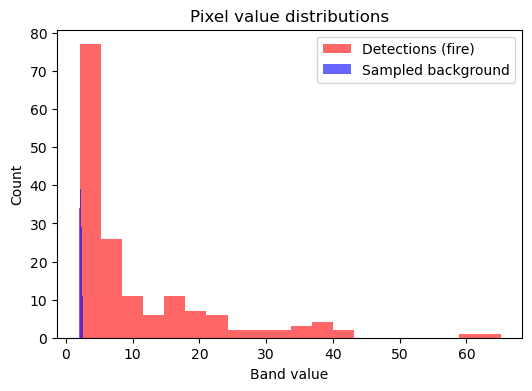

In [2]:
import matplotlib.pyplot as plt

# Compare the raw band values at positives vs. negatives
vals_pos = band[pos_rc[:,0], pos_rc[:,1]]
vals_neg = band.reshape(-1)[neg_sample]

plt.figure(figsize=(6,4))
plt.hist(vals_pos, bins=20, alpha=0.6, label="Detections (fire)", color="red")
plt.hist(vals_neg, bins=20, alpha=0.6, label="Sampled background", color="blue")
plt.xlabel("Band value")
plt.ylabel("Count")
plt.legend()
plt.title("Pixel value distributions")
plt.show()


In [3]:
# from sklearn.metrics import roc_curve, auc

# fpr, tpr, _ = roc_curve(yte, proba_te)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(5,5))
# plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
# plt.plot([0,1],[0,1],'--',color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC curve")
# plt.legend()
# plt.show()


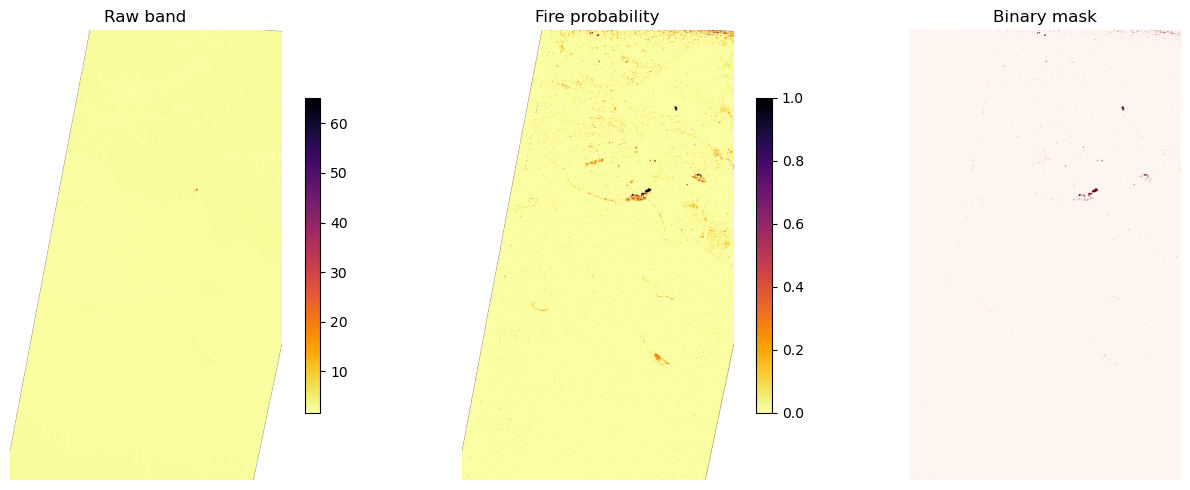

In [10]:
# Pick a bounding box around detections for zoom-in
rmin, rmax = pos_rc[:,0].min()-20, pos_rc[:,0].max()+20
cmin, cmax = pos_rc[:,1].min()-20, pos_rc[:,1].max()+20

fig, axs = plt.subplots(1,3,figsize=(14,5))

# Raw band
im0 = axs[0].imshow(band[rmin:rmax, cmin:cmax], cmap="inferno_r")
axs[0].set_title("Raw band")
plt.colorbar(im0, ax=axs[0], shrink=0.7)

# Probability
im1 = axs[1].imshow(prob[rmin:rmax, cmin:cmax], cmap="inferno_r")#, vmin=0, vmax=1)
axs[1].set_title("Fire probability")
plt.colorbar(im1, ax=axs[1], shrink=0.7)

# Mask
axs[2].imshow(mask[rmin:rmax, cmin:cmax], cmap="Reds")
axs[2].set_title("Binary mask")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


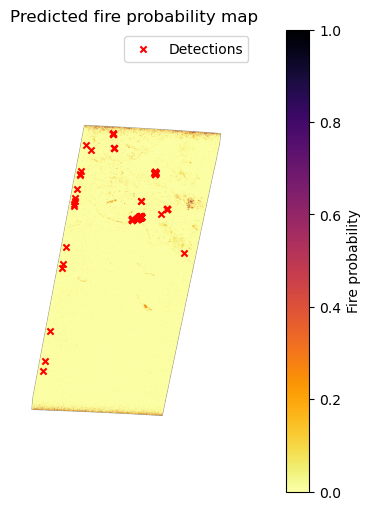

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(prob, cmap="inferno_r", vmin=0, vmax=1)
plt.colorbar(label="Fire probability")
plt.scatter(pos_rc[:,1], pos_rc[:,0], c="red", s=20, marker="x", label="Detections")
plt.title("Predicted fire probability map")
plt.legend()
plt.axis("off")
plt.show()


In [14]:
"""
Unsupervised fire picker (single-band GeoTIFF, EPSG:3857)

What it does
------------
- Loads your raster (nodata=65555.0).
- Builds tiny context features: z-scored value, local mean/std, edges (Sobel), LoG.
- Fits a 3-component Gaussian Mixture (GMM) on a subsample of valid pixels.
- Chooses the "hottest" component as fire-like (highest mean raw value, boosted by LoG).
- Writes:
    fire_prob.tif  -> posterior probability of fire-like component (0..1, float32)
    fire_mask.tif  -> cleaned binary mask (uint8, {0,1})

Tune these if needed
--------------------
N_COMPONENTS, SAMPLE_PIX, MIN_OBJECT_PIX, PROB_THRESH
"""

# ---------- USER SETTINGS ----------
RASTER_PATH   = "Dataset_1/F002_L1__IR__L2L1M0__2025-01-10T215412.018348Z_2025-04-10T154832.806087Z_97706189_MWIR.tif"   # your GeoTIFF path
OUT_PROB_TIF  = "fire_prob.tif"
OUT_MASK_TIF  = "fire_mask.tif"
OUT_POLYGONS  = "fire_polygons.geojson"  # set to None if you don't want vectors

# Unsupervised knobs
N_COMPONENTS  = 3        # GMM clusters
SAMPLE_PIX    = 200_000  # pixels to subsample for fitting (speed)
PROB_THRESH   = 0.6      # probability cutoff for binary mask
MIN_OBJECT_PIX = 16      # drop tiny speckles
# -----------------------------------

import numpy as np
import rasterio
from rasterio.features import shapes
from rasterio.transform import Affine
from sklearn.mixture import GaussianMixture
from scipy.ndimage import uniform_filter, gaussian_laplace, sobel, binary_opening, binary_closing, label
import json

# -----------------------
# 1) LOAD RASTER & CLEAN
# -----------------------
with rasterio.open(RASTER_PATH) as src:
    prof = src.profile.copy()
    band = src.read(1).astype(np.float32)
    transform = src.transform
    crs = src.crs
    nodata = prof.get("nodata", 65555.0)

valid = np.isfinite(band) & (band != nodata)
band = np.where(valid, band, np.nan)

# Z-score over valid pixels (robust enough here)
mu = np.nanmean(band)
sd = np.nanstd(band) + 1e-6
z = (band - mu) / sd

# ------------------------------------------------
# 2) SIMPLE LOCAL FEATURES (FAST + USEFUL)
# ------------------------------------------------
def nanmean_filter(x, size):
    v = np.isfinite(x).astype(np.float32)
    s = uniform_filter(np.nan_to_num(x, nan=0.0), size=size, mode="nearest")
    c = uniform_filter(v, size=size, mode="nearest")
    return np.where(c > 0, s / np.maximum(c, 1e-6), np.nan)

mean3 = nanmean_filter(z, 3)
sq = z**2
mean3_sq = nanmean_filter(sq, 3)
std3 = np.sqrt(np.clip(mean3_sq - mean3**2, 0, None))

sx = sobel(z, axis=1, mode="nearest")
sy = sobel(z, axis=0, mode="nearest")
grad_mag = np.hypot(sx, sy)

log_resp = -gaussian_laplace(z, sigma=1)  # positive on hot spots

# Feature stack: keep it tiny and generic
feat = np.stack([z, mean3, std3, grad_mag, log_resp], axis=-1)
feat = np.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)

H, W, F = feat.shape
feat_flat = feat.reshape(-1, F)
valid_flat = valid.reshape(-1)

# ------------------------------------------------
# 3) GMM FIT ON A SUBSAMPLE OF VALID PIXELS
# ------------------------------------------------
idx_valid = np.flatnonzero(valid_flat)
if len(idx_valid) == 0:
    raise ValueError("No valid pixels in raster.")

rng = np.random.default_rng(42)
if len(idx_valid) > SAMPLE_PIX:
    sample_idx = rng.choice(idx_valid, size=SAMPLE_PIX, replace=False)
else:
    sample_idx = idx_valid

X_fit = feat_flat[sample_idx]

gmm = GaussianMixture(
    n_components=N_COMPONENTS,
    covariance_type="full",
    reg_covar=1e-6,
    random_state=42
)
gmm.fit(X_fit)

# ------------------------------------------------
# 4) PICK THE "FIRE-LIKE" CLUSTER
# ------------------------------------------------
# Heuristic: the cluster with the highest combined score:
# score = w0 * mean(raw z) + w1 * mean(log_resp) + w2 * mean(grad_mag)
# (fires tend to be bright with blob-like LoG response; grad helps separate edges)
w0, w1, w2 = 1.0, 0.7, 0.3

# Estimate component-wise feature means from the subsample
resp = gmm.predict_proba(X_fit)  # [n_sample, n_components]
means = []
for k in range(N_COMPONENTS):
    w = resp[:, k][:, None]
    m = (w * X_fit).sum(axis=0) / (resp[:, k].sum() + 1e-9)
    means.append(m)
means = np.vstack(means)  # [K, F]

# Features index map for readability
IZ, IMEAN3, ISTD3, IGRAD, ILOG = 0, 1, 2, 3, 4
scores = w0*means[:, IZ] + w1*means[:, ILOG] + w2*means[:, IGRAD]
fire_comp = int(np.argmax(scores))

# ------------------------------------------------
# 5) POSTERIOR PROBABILITY MAP & BINARY MASK
# ------------------------------------------------
prob = np.full(H*W, np.nan, dtype=np.float32)
prob_valid = gmm.predict_proba(feat_flat[valid_flat])[:, fire_comp]
prob[valid_flat] = prob_valid
prob = prob.reshape(H, W)

# Threshold & clean
mask = (prob >= PROB_THRESH).astype(np.uint8)
mask[~valid] = 0

# Morphological speckle cleanup
if MIN_OBJECT_PIX > 1:
    # Light opening/closing to reduce salt-and-pepper
    mask = binary_opening(mask, structure=np.ones((3,3))).astype(np.uint8)
    mask = binary_closing(mask, structure=np.ones((3,3))).astype(np.uint8)
    # Remove tiny connected components
    lbl, nlab = label(mask)
    if nlab > 0:
        counts = np.bincount(lbl.ravel())
        small = np.isin(lbl, np.where(counts < MIN_OBJECT_PIX)[0])
        mask[small] = 0

# ---------------------------------------
# 6) SAVE PROBABILITY + MASK AS GEOTIFFS
# ---------------------------------------
prob_prof = prof.copy()
prob_prof.update(dtype="float32", count=1, nodata=None, compress="deflate", predictor=2)
with rasterio.open(OUT_PROB_TIF, "w", **prob_prof) as dst:
    dst.write(prob, 1)

mask_prof = prof.copy()
mask_prof.update(dtype="uint8", count=1, nodata=0, compress="deflate")
with rasterio.open(OUT_MASK_TIF, "w", **mask_prof) as dst:
    dst.write(mask.astype(np.uint8), 1)

print(f"Wrote {OUT_PROB_TIF} and {OUT_MASK_TIF}")

# ------------------------------------------------
# 7) OPTIONAL: EXPORT POLYGONS (VECTOR OUTPUT)
# ------------------------------------------------
if OUT_POLYGONS:
    geoms = []
    for geom, val in shapes(mask.astype(np.uint8), mask=mask.astype(bool), transform=transform):
        if val == 1:
            geoms.append({
                "type": "Feature",
                "properties": {},
                "geometry": geom
            })
    fc = {"type": "FeatureCollection", "features": geoms}
    with open(OUT_POLYGONS, "w") as f:
        json.dump(fc, f)
    print(f"Wrote {OUT_POLYGONS}")


Wrote fire_prob.tif and fire_mask.tif
Wrote fire_polygons.geojson


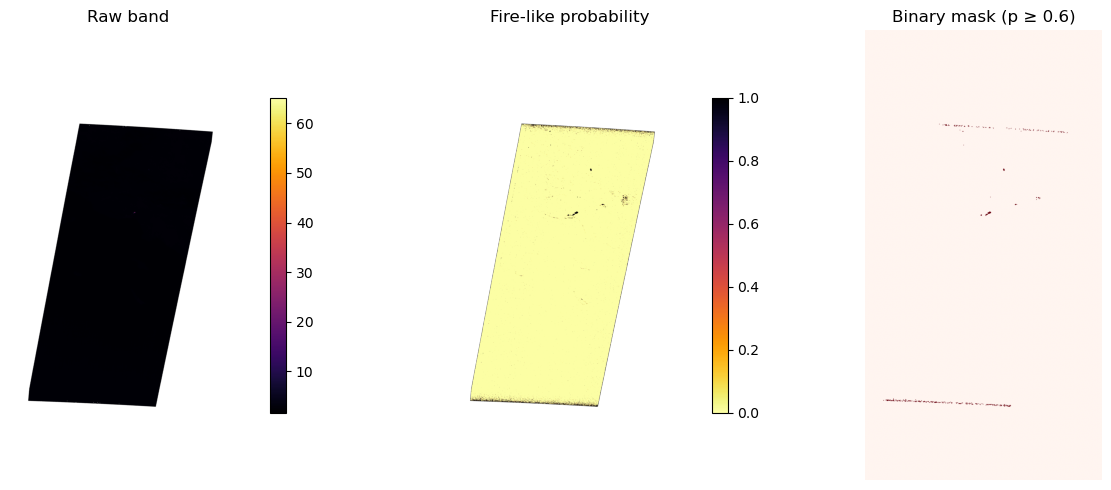

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(14,5))
im0 = axs[0].imshow(band, cmap="inferno")
axs[0].set_title("Raw band"); axs[0].axis("off"); plt.colorbar(im0, ax=axs[0], shrink=0.7)

im1 = axs[1].imshow(prob, vmin=0, vmax=1, cmap="inferno_r")
axs[1].set_title("Fire-like probability"); axs[1].axis("off"); plt.colorbar(im1, ax=axs[1], shrink=0.7)

im2 = axs[2].imshow(mask, cmap="Reds")
axs[2].set_title(f"Binary mask (p ≥ {PROB_THRESH})"); axs[2].axis("off")

plt.tight_layout(); plt.show()
